In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import textdistance
import string
import re
from collections import defaultdict

In [43]:
from research.strings import VIOLATIONS, MONTHS, INSPECTORS

In [29]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
df_canvass["critical_found"] = df_canvass[VIOLATIONS].max(axis=1)
df_canvass["model_deployed"] = (df_canvass["year"].values >= 2015).astype(int)
print("Read {} canvass records.".format(len(df_canvass)))

Read 50462 canvass records.


In [4]:
df_complaint = pd.read_csv("data/complaint_records.csv.gz")
df_complaint["critical_found"] = df_complaint[VIOLATIONS].max(axis=1)
print("Read {} complaint records.".format(len(df_complaint)))

Read 17088 complaint records.


In [130]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [131]:
def clean_name(original, backup, fallback="nullname"):
    name = fallback
    if not pd.isna(original):
        name = original
    elif not pd.isna(backup):
        name = backup
    clean = name.casefold()
    for p in list(string.punctuation):
        clean = clean.replace(p, "")
    clean = clean.replace(" ", "_")
    return clean

In [132]:
name_opts = df_canvass[["aka_name", "dba_name"]].to_dict(orient="records")
df_canvass["clean_name"] = [clean_name(n["aka_name"], n["dba_name"]) for n in name_opts]
name_labels_dict = defaultdict(lambda: [])
label_names_dict = defaultdict(lambda: [])
rest_names = []
with open("models/names/all_names.txt", "r") as all_names_file:
    rest_names = [re.sub("\.txt$", "", f) for f in all_names_file.read().split()]
    for rest_name in rest_names:
        with open("models/names/" + rest_name + ".txt", "r") as name_file:
            all_names = [re.sub("\.txt$", "", f) for f in name_file.read().split()]
            for name in all_names:
                name_labels_dict[name].append(rest_name)
                label_names_dict[rest_name].append(name)
for rest_name in label_names_dict:
    label_names_dict[rest_name] = np.unique(label_names_dict[rest_name])
print("Read {} name clusters.".format(len(rest_names)))
print("Mapped {} unique labels.".format(len(label_names_dict)))
print("Mapped {} unique names.".format(len(name_labels_dict)))

Read 51 name clusters.
Mapped 51 unique labels.
Mapped 458 unique names.


In [133]:
mlb = MultiLabelBinarizer()
all_rest_labels = df_canvass["clean_name"].apply(lambda n: name_labels_dict[n])
all_rest_vecs = mlb.fit_transform(all_rest_labels)
in_top_rests = all_rest_vecs.max(axis=1)
rest_vecs = all_rest_vecs[in_top_rests.astype(bool)]
df_rests = df_canvass[in_top_rests.astype(bool)]
print("Found {} inspections included in name clusters.".format(sum(in_top_rests)))
print("Filtered {} vectors.".format(len(rest_vecs)))
print("Filtered {} rows.".format(len(df_rests)))

Found 8783 inspections included in name clusters.
Filtered 8783 vectors.
Filtered 8783 rows.


In [135]:
df_canvass["is_chain"] = in_top_rests.astype(int)
df_canvass["is_chain"].sum()

8783

In [134]:
df_labels = pd.DataFrame([(c, np.sum([
    len(df_rests.query("clean_name == '{}'".format(n))) for n in a
])) for c, a in label_names_dict.items()], columns=["restaurant", "inspections"])
df_labels.sort_values(by="inspections", ascending=False).head(10)

,restaurant,inspections
42,subway,2102
13,dunkin_donuts,961
41,starbucks,857
26,mcdonalds,433
35,potbelly,386
5,baskin_robbins,355
21,jimmy_johns,343
9,chipotle,215
34,popeyes,192
22,kfc,157


In [23]:
df_canvass.query("aka_name == 'KFC'").groupby("license_id")["inspection_id"].count().sort_values(ascending=False)

license_id
189348     10
1695369     7
2153034     6
2146635     6
2293813     5
2146643     3
2189443     3
82621       2
2146634     2
20481       2
2438195     2
2442910     2
2442911     2
2483751     1
2146638     1
2437675     1
2475925     1
2483758     1
Name: inspection_id, dtype: int64

In [24]:
s = df_canvass.query("license_id == 189348").sort_values(by="inspection_date", ascending=True)
s[["inspection_date", "year", "month", "week", "aka_name", "address", "results", "critical_found"] + VIOLATIONS]

,inspection_date,year,month,week,aka_name,address,results,critical_found,V1,V2,...,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
4270,2010-11-22T00:00:00.000,2010,11,47,KFC,3357 W PETERSON AVE,Pass,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23543,2011-05-10T00:00:00.000,2011,5,19,KFC,3357 W PETERSON AVE,Pass,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45371,2013-05-08T00:00:00.000,2013,5,19,KFC,3357 W PETERSON AVE,Fail,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8928,2014-01-29T00:00:00.000,2014,1,5,KFC,3357 W PETERSON AVE,Fail,1,0,0,...,0,0,0,0,0,0,1,0,0,0
42735,2014-09-09T00:00:00.000,2014,9,37,KFC,3357 W PETERSON AVE,Fail,1,0,0,...,0,0,0,0,0,0,1,0,0,0
42939,2015-01-16T00:00:00.000,2015,1,3,KFC,3357 W PETERSON AVE,Pass,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42411,2016-01-14T00:00:00.000,2016,1,2,KFC,3357 W PETERSON AVE,Fail,1,0,0,...,0,0,0,0,0,1,0,0,0,0
48282,2017-01-06T00:00:00.000,2017,1,1,KFC,3357 W PETERSON AVE,Pass,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8881,2017-11-13T00:00:00.000,2017,11,46,KFC,3357 W PETERSON AVE,Pass,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24004,2018-05-22T00:00:00.000,2018,5,21,KFC,3357 W PETERSON AVE,Pass,0,0,0,...,0,0,0,0,0,0,0,0,0,0


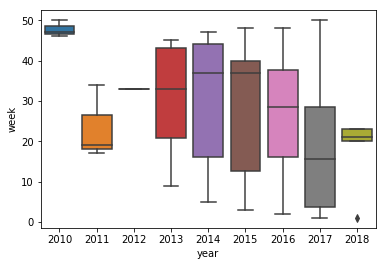

In [28]:
sns.boxplot(x="year", y="week", data=df_canvass.query("aka_name == 'KFC'")[["year", "week"]])

In [38]:
df_canvass.groupby(by=["model_deployed", "license_id"])["week"].mean().groupby("model_deployed").mean()

model_deployed
0    26.363218
1    25.028689
Name: week, dtype: float64

In [283]:
def plot_grouped_hit_rate(df_made, targets, group_col, labels):
    pal = sns.color_palette("hls", 2)
    l0 = labels[0]
    l1 = labels[1]
    for target in targets:
        yc_gp = pd.DataFrame(df_made.groupby(["year", group_col])[target].mean()).sort_values(by="year")
        ser_chain = yc_gp.query("{} == 1".format(group_col))
        ser_other = yc_gp.query("{} == 0".format(group_col))
        sns.lineplot(x=ser_chain.index.levels[0], y=ser_chain.values.flatten(), color=pal[0], label=l0, marker="^")
        sns.lineplot(x=ser_other.index.levels[0], y=ser_other.values.flatten(), color=pal[1], label=l1, marker="o")
        y_max = max(1.1 * yc_gp.values.max(), 0.1)
        plt.axvline(2015, linestyle="--", color="black")
        plt.text(2015.1, 0.95 * y_max, "Model Deployed")
        plt.ylim((0, y_max))
        plt.xlabel("Year")
        plt.ylabel("Hit Rate")
        plt.title("Hit Rate of {}".format(target))
        plt.grid(linestyle="--")
        plt.legend(frameon=False, bbox_to_anchor=(1.15, 1.0))
        plt.gcf().set_size_inches(10, 6)
        plt.show()

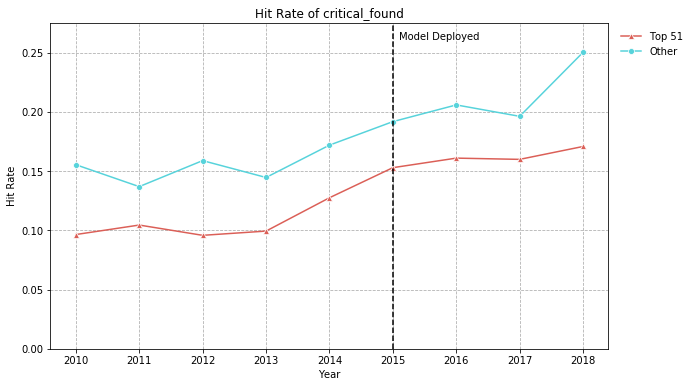

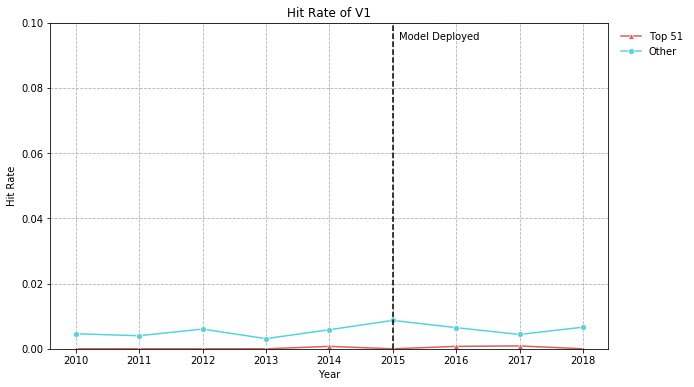

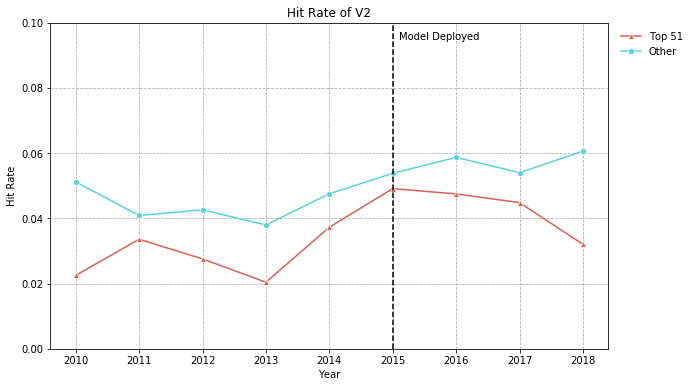

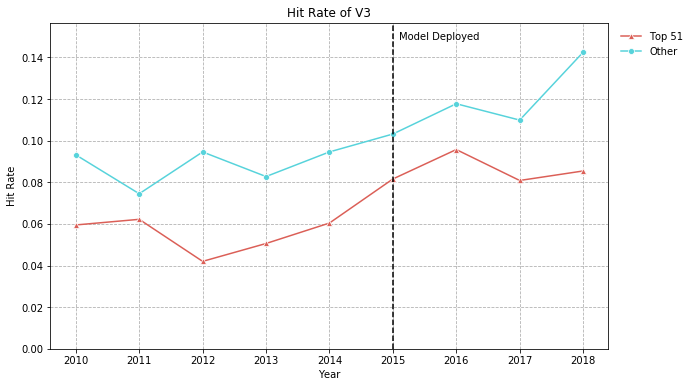

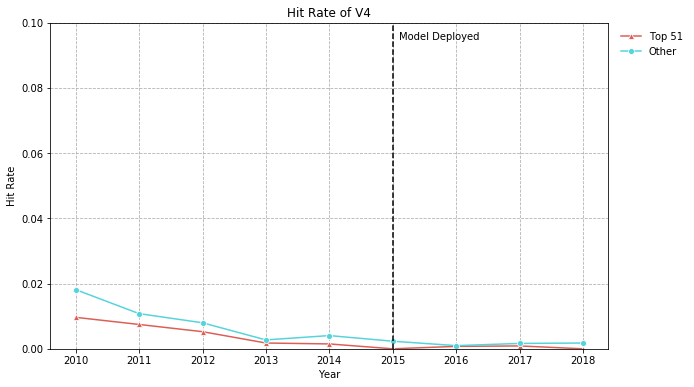

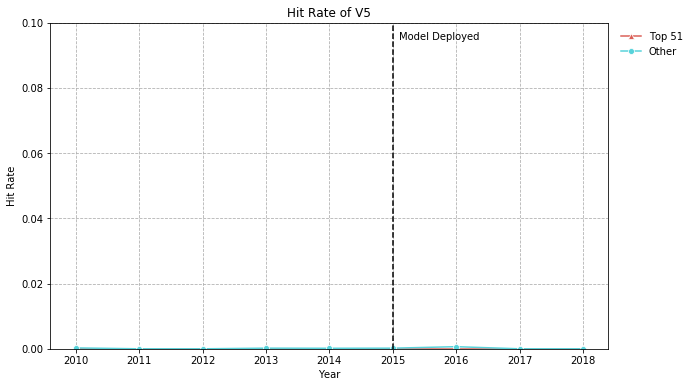

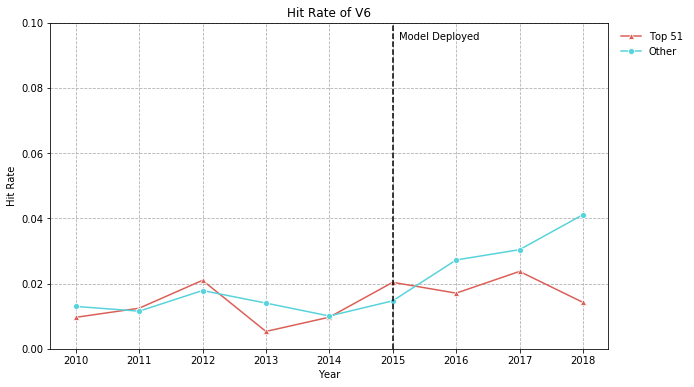

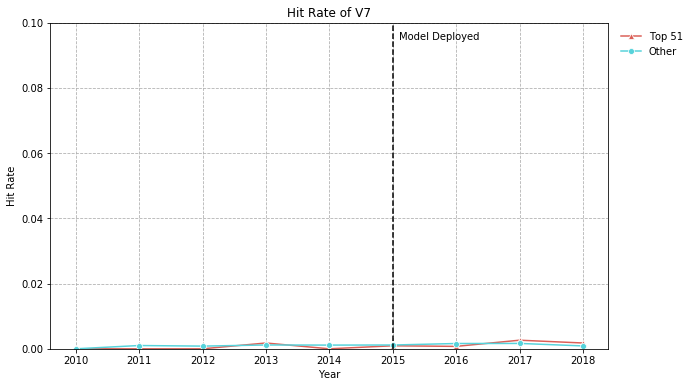

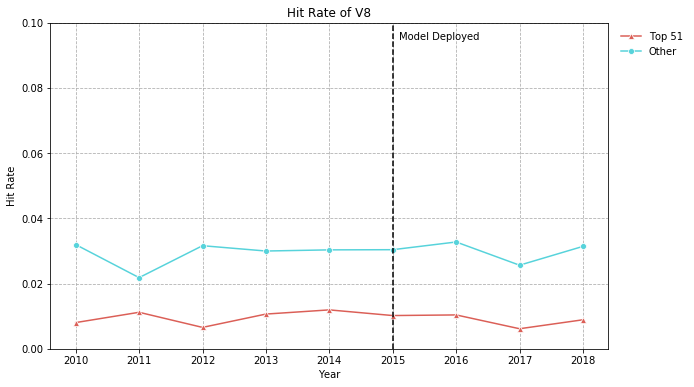

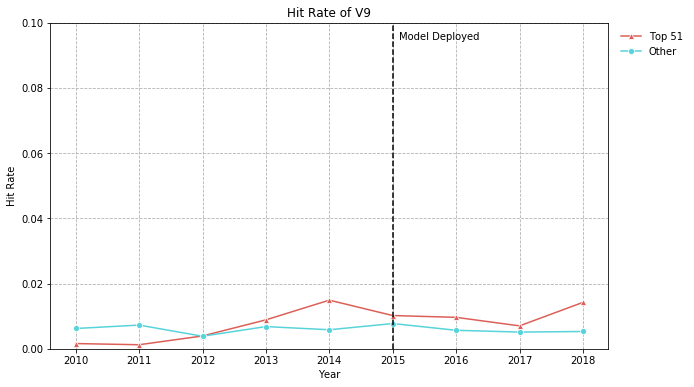

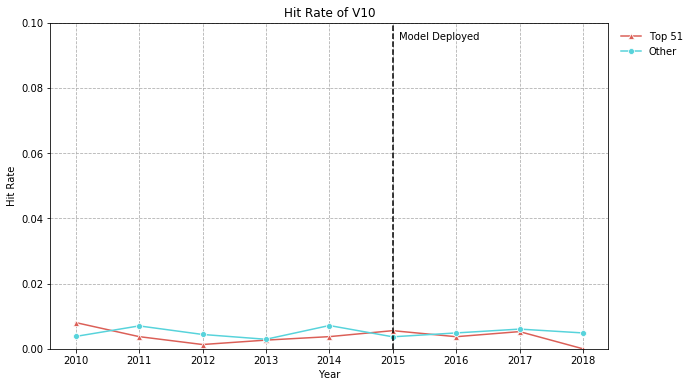

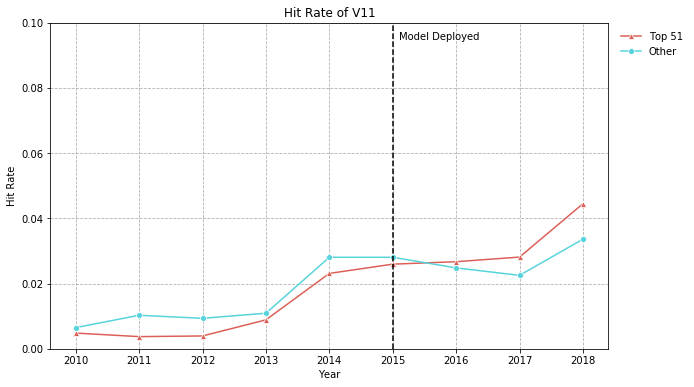

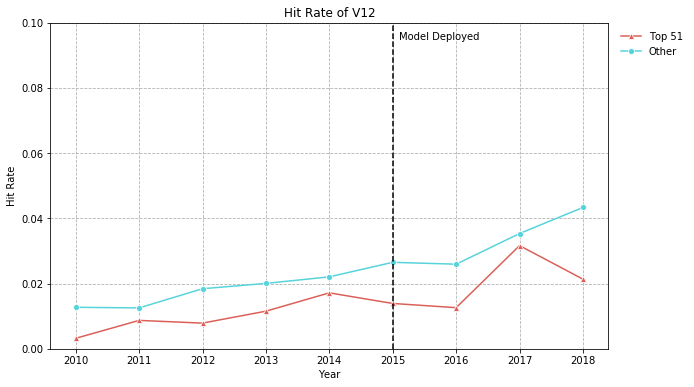

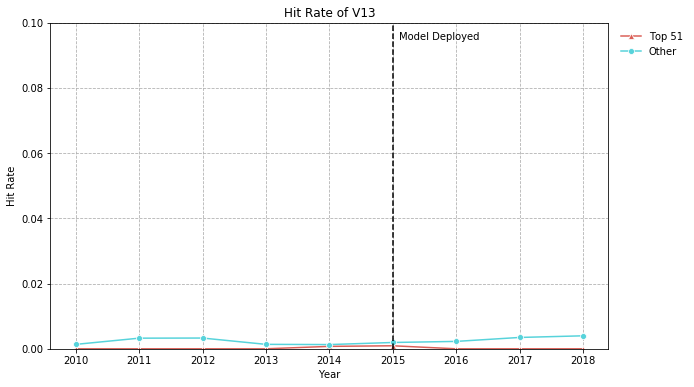

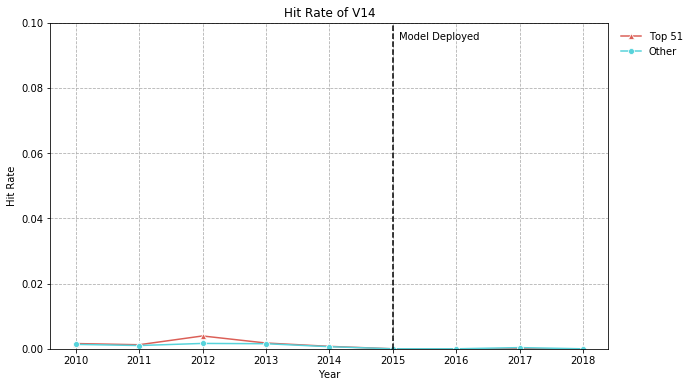

In [284]:
plot_grouped_hit_rate(
    targets=["critical_found"] + VIOLATIONS,
    df_made=df_canvass,
    group_col="is_chain",
    labels=["Top 51", "Other"]
)

In [243]:
before_map = defaultdict(lambda: [])
after_map = defaultdict(lambda: [])
for rec in df_canvass.to_dict(orient="records"):
    if rec["model_deployed"] > 0:
        before_map[rec["license_id"]].append(rec["week"])
    else:
        after_map[rec["license_id"]].append(rec["week"])

In [249]:
in_both = list(set(before_map.keys()).intersection(set(after_map.keys())))

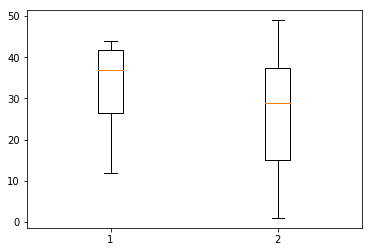

In [257]:
lid = in_both[0]
plt.boxplot([before_map[lid], after_map[lid]])
plt.show()

In [262]:
rows = []
for lid in in_both:
    bm = before_map[lid]
    am = after_map[lid]
    b_mu = np.mean(bm)
    a_mu = np.mean(am)
    b_sig = np.std(bm)
    a_sig = np.std(am)
    rows.append({
        "license_id": lid,
        "n_before": len(bm),
        "n_after": len(am),
        "mean_before": b_mu,
        "mean_after": a_mu,
        "std_before": b_sig,
        "std_after": a_sig
    })
wdf = pd.DataFrame(rows)

In [272]:
# Positive mean_change => inspections moved later, negative => earlier
wdf["mean_change"] = wdf["mean_after"] - wdf["mean_before"]
# Positive std_change => wider distribution, negative => smaller
wdf["std_change"] = wdf["std_after"] - wdf["std_before"]
wdf["n_mean"] = (wdf["n_after"] + wdf["n_before"]) / 2
wdf["earlier"] = (wdf["mean_change"] < 0).astype(int)
wdf.sort_values(by=["n_before", "mean_change"], ascending=[False, True]).head()

,license_id,mean_after,mean_before,n_after,n_before,std_after,std_before,mean_change,std_change,n_mean,earlier
0,0,27.333333,33.900000,15,10,13.404808,10.084146,-6.566667,3.320662,12.5,1
5782,32317,17.625000,21.625000,8,8,9.707439,14.645285,-4.000000,-4.937846,8.0,1
5742,1801484,23.285714,21.375000,7,8,15.925849,17.124088,1.910714,-1.198239,7.5,0
5513,2192968,5.000000,24.428571,1,7,0.000000,16.211611,-19.428571,-16.211611,4.0,1
2613,2109577,19.200000,35.000000,5,7,13.789851,11.904381,-15.800000,1.885470,6.0,1


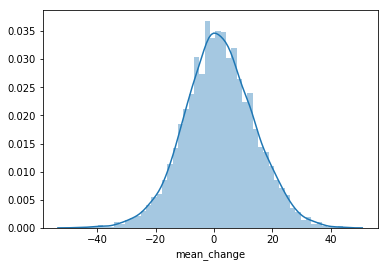

In [260]:
sns.distplot(wdf["mean_change"])

In [281]:
earlier_lids = set(wdf.query("earlier > 0").license_id.values)
df_canvass["earlier"] = df_canvass["license_id"].apply(lambda lid: lid in earlier_lids).astype(int)

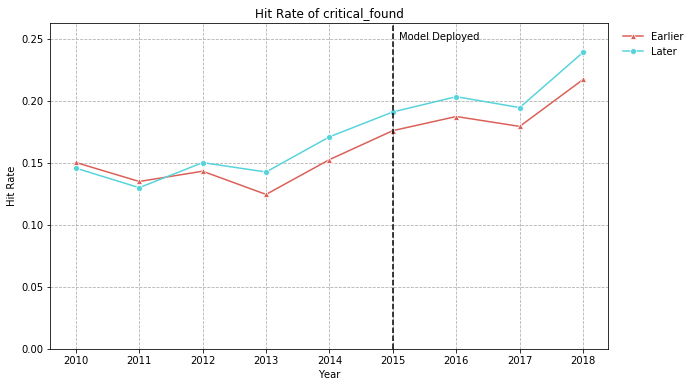

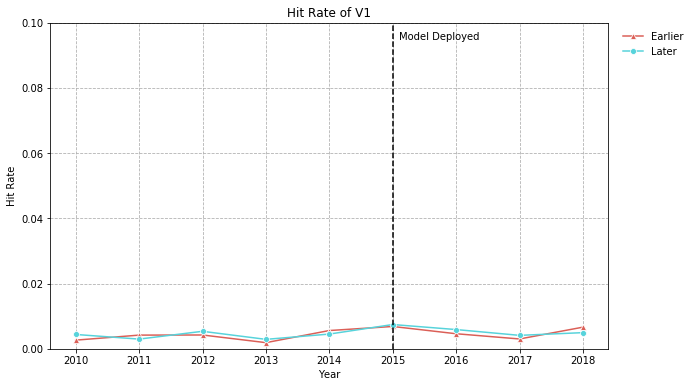

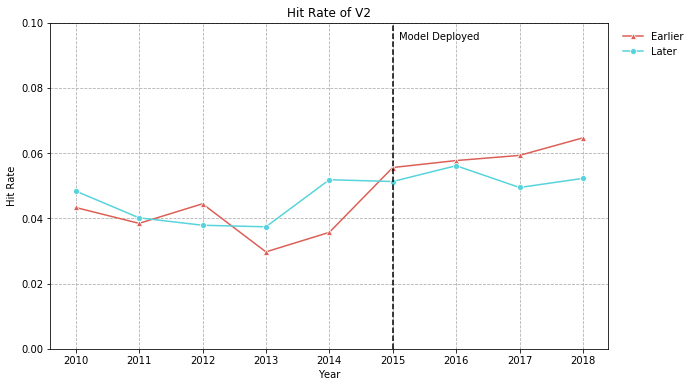

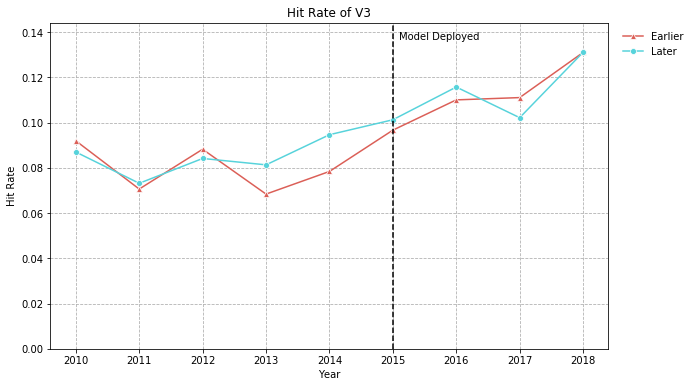

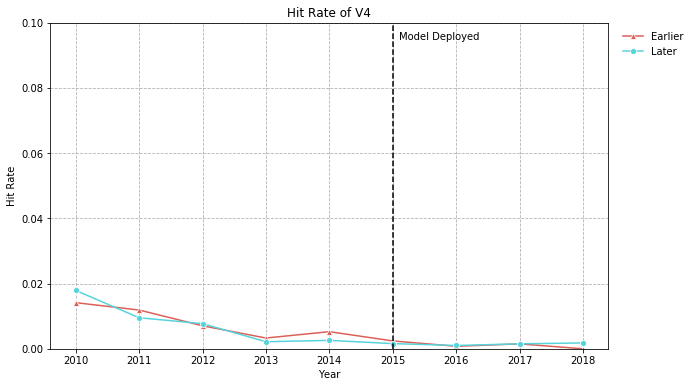

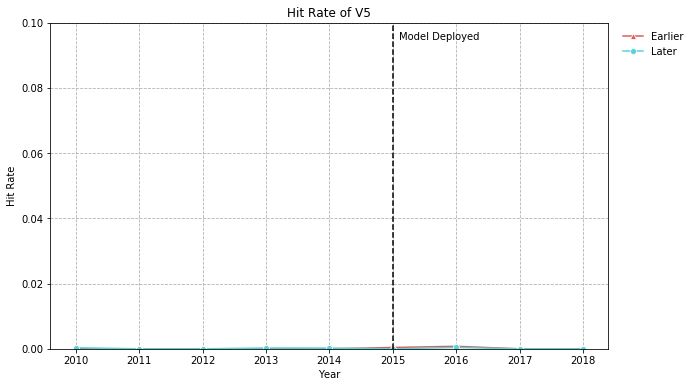

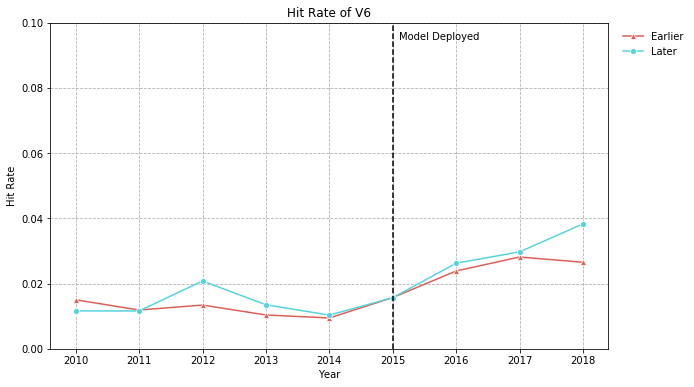

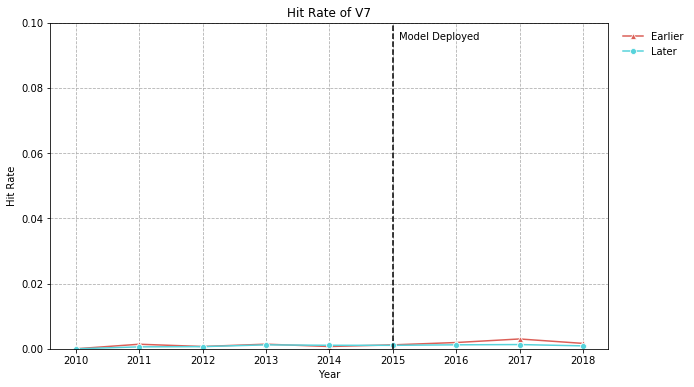

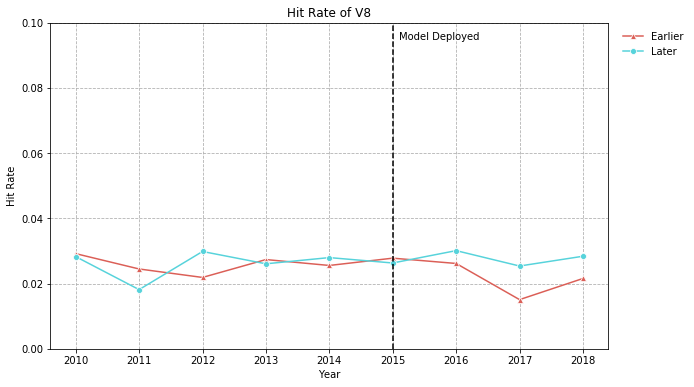

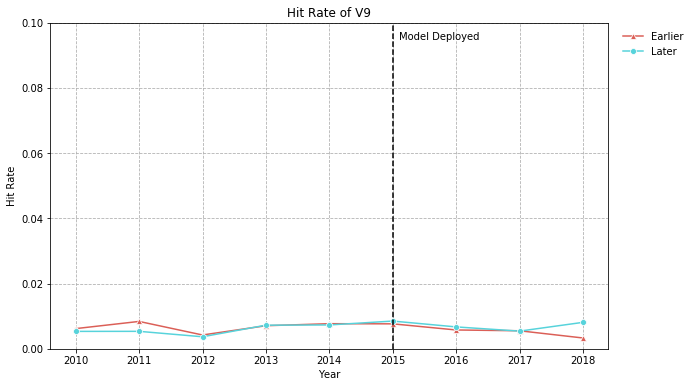

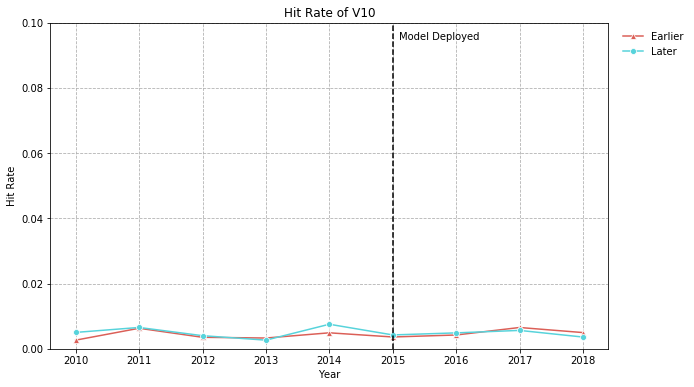

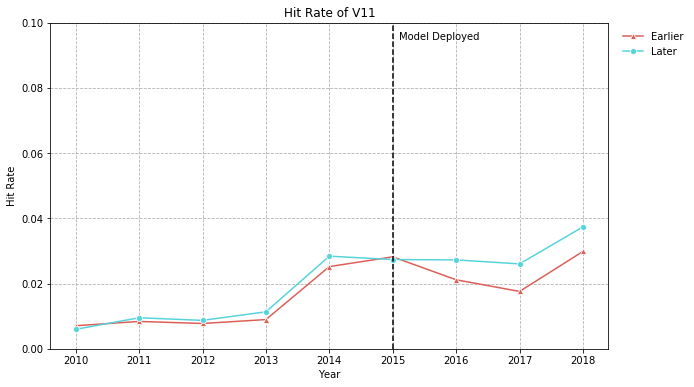

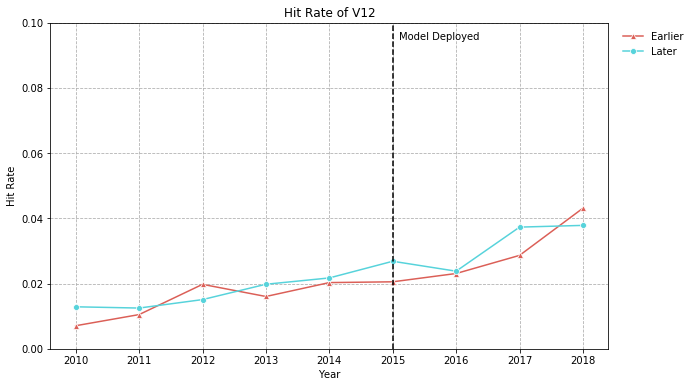

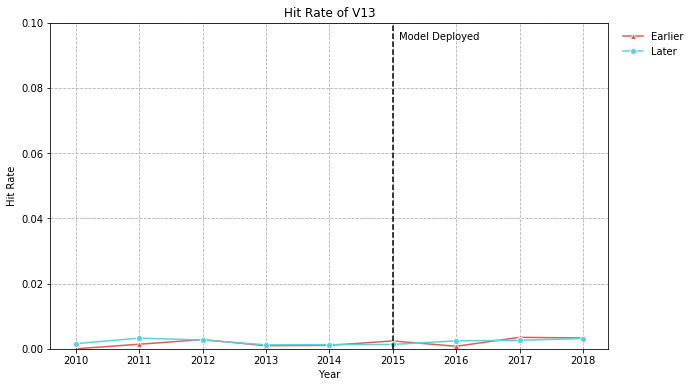

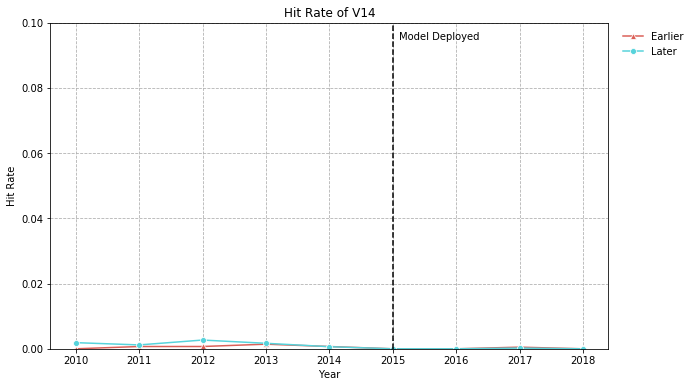

In [285]:
plot_grouped_hit_rate(
    targets=["critical_found"] + VIOLATIONS,
    df_made=df_canvass,
    group_col="earlier",
    labels=["Earlier", "Later"]
)

In [309]:
hr_gp = df_canvass.groupby(["year", "week"])["critical_found"].mean()

In [318]:
vals = []
years = hr_gp.index.levels[0]
weeks = hr_gp.index.levels[1]
for y in years:
    for w in weeks:
        hr = np.nan
        if y in hr_gp:
            if w in hr_gp[y]:
                hr = hr_gp[y][w]
        vals.append({
            "year_week": "{0}-{1:02}".format(y, w),
            "year": y,
            "week": w,
            "hit_rate": hr
        })
ym_df = pd.DataFrame(vals)

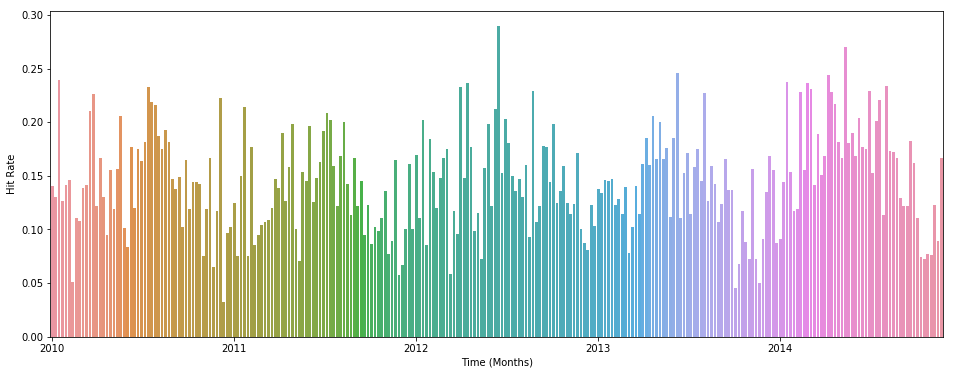

In [320]:
ym_sub = ym_df.query("year < 2015").dropna()
sns.barplot(x="year_week", y="hit_rate", data=ym_sub)
plt.xticks(range(0, len(ym_sub), len(weeks)), ym_sub["year"].unique())
plt.xlabel("Time (Months)")
plt.ylabel("Hit Rate")
plt.gcf().set_size_inches(16, 6)
plt.show()

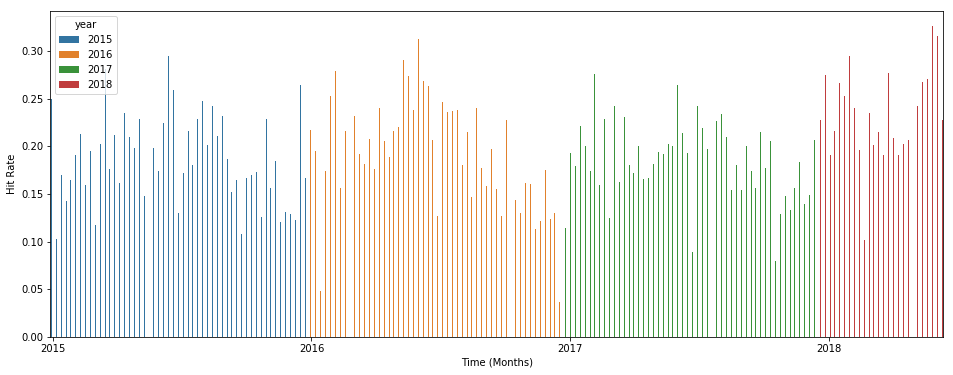

In [321]:
ym_sub = ym_df.query("year >= 2015").dropna()
sns.barplot(x="year_week", y="hit_rate", hue="year", data=ym_sub)
plt.xticks(range(0, len(ym_sub), len(weeks)), ym_sub["year"].unique())
plt.xlabel("Time (Months)")
plt.ylabel("Hit Rate")
plt.gcf().set_size_inches(16, 6)
plt.show()

In [56]:
from research.utils import get_crit_mat

In [126]:
data = pd.read_csv("data/inspections.csv")
data["inspector"] = data[INSPECTORS].idxmax(axis=1)
crit_mat = get_crit_mat(data)
print("Found {} critical violation labels.".format(len(crit_mat.columns)))

# Merge on inspection ID
inspection_id = "Inspection_ID"
crit_mat[inspection_id] = data[inspection_id]
merged = data.set_index(inspection_id).join(crit_mat.set_index(inspection_id))
merged = merged.reset_index()
merged["license_id"] = merged["license_id"].astype(int).astype(str)
print("Merged: {} records.".format(len(merged)))

Found 14 critical violation labels.
Merged: 18712 records.


In [127]:
viols = ["criticalFound"] + VIOLATIONS
imat_raw = merged[["inspector"] + viols].groupby("inspector")[viols].mean()
imat = imat_raw.sort_values(by="criticalFound", ascending=False)
imat.round(3)

,criticalFound,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
inspector,,,,,,,,,,,,,,,
Inspector_purple,0.408,0.009,0.097,0.306,0.016,0.0,0.020,0.002,0.069,0.012,0.012,0.034,0.057,0.005,0.004
Inspector_blue,0.255,0.008,0.065,0.128,0.012,0.0,0.031,0.001,0.046,0.008,0.005,0.026,0.042,0.004,0.001
Inspector_orange,0.138,0.005,0.027,0.060,0.003,0.0,0.016,0.001,0.020,0.009,0.006,0.018,0.020,0.002,0.001
Inspector_green,0.097,0.002,0.033,0.051,0.002,0.0,0.004,0.000,0.018,0.008,0.004,0.007,0.006,0.002,0.001
Inspector_yellow,0.060,0.002,0.013,0.026,0.000,0.0,0.002,0.001,0.008,0.005,0.001,0.007,0.008,0.001,0.002
Inspector_brown,0.025,0.002,0.006,0.013,0.002,0.0,0.001,0.000,0.004,0.002,0.001,0.003,0.003,0.001,0.000


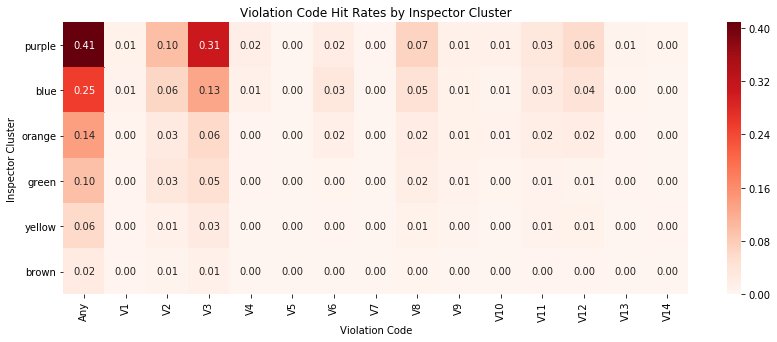

In [128]:
sns.heatmap(imat, cmap="Reds", annot=True, fmt=".2f")
plt.xticks(np.arange(0.5, len(viols) + 0.5), ["Any"] + VIOLATIONS)
plt.yticks(np.arange(0.5, len(INSPECTORS) + 0.5), [ins.split("_")[1] for ins in imat.index])
plt.xlabel("Violation Code")
plt.ylabel("Inspector Cluster")
plt.title("Violation Code Hit Rates by Inspector Cluster")
plt.gcf().set_size_inches(14, 5)
plt.show()

In [129]:
merged.groupby("license_id")["inspector"].unique().apply(lambda a: len(a)).sort_values(ascending=False).head()

license_id
1932       5
23051      5
2074325    4
1045365    4
38123      4
Name: inspector, dtype: int64